## 模型说明

本机上下载的是mindspore cpu版本，所以 device_target ="CPU"，在服务器上 device_target ="GPU"
本模型参考的是官方示例教程中的DCGan网络模型
本模型实现的是生成"The simpsons"电影中人物图像

## 参数说明

由于训练周期较小，所以学习率设置大一点，有利于快速收敛

In [1]:
#参数定义
from mindspore import context

# 选择执行模式为图模式；指定训练使用的平台为"GPU"，如需使用昇腾硬件可将其替换为"Ascend"
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

data_root = "D:/Desktop/simpsons/train"  # 数据集根目录
workers = 4  # 载入数据线程数
batch_size = 128  # 批量大小
image_size = 64  # 训练图像空间大小，所有图像都将调整为该大小
nc = 3  # 图像彩色通道数，对于彩色图像为3
nz = 100  # 隐向量的长度
ngf = 64  # 特征图在生成器中的大小
ndf = 64  # 特征图在判别器中的大小
num_epochs = 300  # 训练周期数
lr = 0.0004  # 学习率
beta1 = 0.5  # Adam优化器的beta1超参数

## 操作说明

transform_img将图片rsize成3*64*64，图片是以图片中心为基准裁剪的

In [2]:
#数据处理和增强
import numpy as np
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as vision

from mindspore import nn, ops, Tensor
from mindspore import dtype as mstype

def create_dataset_imagenet(dataset_path, num_parallel_workers=None):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path, num_parallel_workers=num_parallel_workers, shuffle=True,
                                     decode=True)
#####################################################
    # 数据增强操作
    transform_img = [
        vision.Resize(image_size),
        vision.CenterCrop(image_size),
        vision.HWC2CHW(),
        lambda x: ((x / 255).astype("float32"), np.random.normal(size=(nz, 1, 1)).astype("float32"))
    ]

    # 数据映射操作
    data_set = data_set.map(input_columns="image", num_parallel_workers=num_parallel_workers, operations=transform_img,
                            output_columns=["image", "latent_code"], column_order=["image", "latent_code"])


    # 批量操作
    data_set = data_set.batch(batch_size)
    return data_set

# 获取处理后的数据集
data = create_dataset_imagenet(data_root, num_parallel_workers=workers)

# 获取数据集大小
size = data.get_dataset_size()

## 可视化部分训练数据


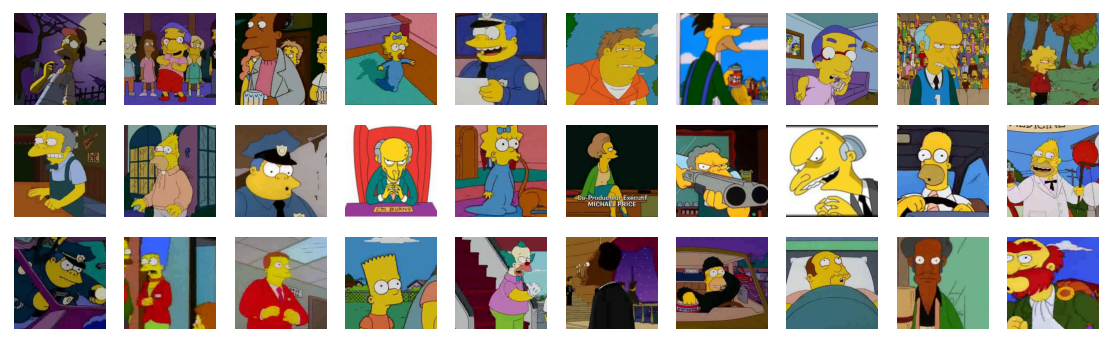

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

data_iter = next(data.create_dict_iterator(output_numpy=True))

# 可视化部分训练数据
plt.figure(figsize=(10, 3), dpi=140)
for i, image in enumerate(data_iter['image'][:30], 1):
    plt.subplot(3, 10, i)
    plt.axis("off")
    plt.imshow(image.transpose(1, 2, 0))
plt.show()

In [3]:
#创建网络
#生成器

from mindspore.common.initializer import Normal

def conv_t(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    """定义转置卷积层"""
    weight_init = Normal(mean=0, sigma=0.02)
    return nn.Conv2dTranspose(in_channels, out_channels,
                              kernel_size=kernel_size, stride=stride, padding=padding,
                              weight_init=weight_init, has_bias=False, pad_mode=pad_mode)

def bn(num_features):
    """定义BatchNorm2d层"""
    gamma_init = Normal(mean=1, sigma=0.02)
    return nn.BatchNorm2d(num_features=num_features, gamma_init=gamma_init)

class Generator(nn.Cell):
    """DCGAN网络生成器"""

    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.SequentialCell()
        self.generator.append(conv_t(nz, ngf * 8, 4, 1, 0))
        self.generator.append(bn(ngf * 8))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf * 8, ngf * 4, 4, 2, 1))
        self.generator.append(bn(ngf * 4))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf * 4, ngf * 2, 4, 2, 1))
        self.generator.append(bn(ngf * 2))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf * 2, ngf, 4, 2, 1))
        self.generator.append(bn(ngf))
        self.generator.append(nn.ReLU())
        self.generator.append(conv_t(ngf, nc, 4, 2, 1))
        self.generator.append(nn.Tanh())

    def construct(self, x):
        return self.generator(x)

# 实例化生成器
netG = Generator()

In [4]:
#判别器

def conv(in_channels, out_channels, kernel_size, stride=1, padding=0, pad_mode="pad"):
    """定义卷积层"""
    weight_init = Normal(mean=0, sigma=0.02)
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight_init, has_bias=False, pad_mode=pad_mode)

class Discriminator(nn.Cell):
    """DCGAN网络判别器"""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.SequentialCell()
        self.discriminator.append(conv(nc, ndf, 4, 2, 1))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf, ndf * 2, 4, 2, 1))
        self.discriminator.append(bn(ndf * 2))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 2, ndf * 4, 4, 2, 1))
        self.discriminator.append(bn(ndf * 4))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 4, ndf * 8, 4, 2, 1))
        self.discriminator.append(bn(ndf * 8))
        self.discriminator.append(nn.LeakyReLU(0.2))
        self.discriminator.append(conv(ndf * 8, 1, 4, 1))
        self.discriminator.append(nn.Sigmoid())

    def construct(self, x):
        return self.discriminator(x)

# 实例化判别器
netD = Discriminator()

In [5]:
#连接网络和损失函数

class WithLossCellG(nn.Cell):
    """连接生成器和损失"""

    def __init__(self, netD, netG, loss_fn):
        super(WithLossCellG, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, latent_code):
        """构建生成器损失计算结构"""
        fake_data = self.netG(latent_code)
        out = self.netD(fake_data)            #判别的结果
        label_real = ops.OnesLike()(out)
        loss = self.loss_fn(out, label_real)               #生成器损失计算
        return loss

In [7]:
#####################################
class WithLossCellD(nn.Cell):
    """连接判别器和损失"""

    def __init__(self, netD, netG, loss_fn):
        super(WithLossCellD, self).__init__(auto_prefix=True)
        self.netD = netD
        self.netG = netG
        self.loss_fn = loss_fn

    def construct(self, real_data, latent_code):
        """构建判别器损失计算结构"""
        out_real = self.netD(real_data)
        label_real = ops.OnesLike()(out_real)
        loss_real = self.loss_fn(out_real, label_real)

        fake_data = self.netG(latent_code)
        fake_data = ops.stop_gradient(fake_data)
        out_fake = self.netD(fake_data)
        label_fake = ops.ZerosLike()(out_fake)
        loss_fake = self.loss_fn(out_fake, label_fake)
        return loss_real + loss_fake

In [8]:
# 定义损失函数
criterion = nn.BCELoss(reduction='mean')

# 创建一批隐向量用来观察G
np.random.seed(1)
fixed_noise = Tensor(np.random.randn(64, nz, 1, 1), dtype=mstype.float32)

# 为生成器和判别器设置优化器
optimizerD = nn.Adam(netD.trainable_params(), learning_rate=lr, beta1=beta1)
optimizerG = nn.Adam(netG.trainable_params(), learning_rate=lr, beta1=beta1)

In [9]:
#训练
class DCGAN(nn.Cell):
    """定义DCGAN网络"""

    def __init__(self, myTrainOneStepCellForD, myTrainOneStepCellForG):
        super(DCGAN, self).__init__(auto_prefix=True)
        self.myTrainOneStepCellForD = myTrainOneStepCellForD
        self.myTrainOneStepCellForG = myTrainOneStepCellForG

    def construct(self, real_data, latent_code):
        output_D = self.myTrainOneStepCellForD(real_data, latent_code).view(-1)
        netD_loss = output_D.mean()
        output_G = self.myTrainOneStepCellForG(latent_code).view(-1)
        netG_loss = output_G.mean()
        return netD_loss, netG_loss

In [10]:

# 实例化WithLossCell
netD_with_criterion = WithLossCellD(netD, netG, criterion)
netG_with_criterion = WithLossCellG(netD, netG, criterion)

# 实例化TrainOneStepCell
myTrainOneStepCellForD = nn.TrainOneStepCell(netD_with_criterion, optimizerD)
myTrainOneStepCellForG = nn.TrainOneStepCell(netG_with_criterion, optimizerG)

In [11]:

from mindspore import save_checkpoint

# 实例化DCGAN网络
dcgan = DCGAN(myTrainOneStepCellForD, myTrainOneStepCellForG)
dcgan.set_train()

# 创建迭代器
data_loader = data.create_dict_iterator(output_numpy=True, num_epochs=num_epochs)
G_losses = []
D_losses = []
image_list = []

## 注释

图片太多了，在服务器上用.py文件运行的，这里不展示训练。

In [ ]:
# 开始循环训练
print("Starting Training Loop...")

for epoch in range(num_epochs):
    # 为每轮训练读入数据
    for i, d in enumerate(data_loader):
        real_data = Tensor(d['image'])       #取真实图片
        latent_code = Tensor(d["latent_code"])        #取假图片
        netD_loss, netG_loss = dcgan(real_data, latent_code)
        if i % 50 == 0 or i == size - 1:
            # 输出训练记录
            print('[%2d/%d][%3d/%d]   Loss_D:%7.4f  Loss_G:%7.4f' % (
                epoch + 1, num_epochs, i + 1, size, netD_loss.asnumpy(), netG_loss.asnumpy()))
        D_losses.append(netD_loss.asnumpy())
        G_losses.append(netG_loss.asnumpy())

    # 每个epoch结束后，使用生成器生成一组图片
    img = netG(fixed_noise)
    image_list.append(img.transpose(0, 2, 3, 1).asnumpy())

    # 保存网络模型参数为ckpt文件
    save_checkpoint(netG, "Generator.ckpt")
    save_checkpoint(netD, "Discriminator.ckpt")

In [ ]:

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G", color='blue')
plt.plot(D_losses, label="D", color='orange')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#隐向量生成过程图像
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def showGif(image_list):
    show_list = []
    fig = plt.figure(figsize=(8, 3), dpi=120)
    for epoch in range(len(image_list)):
        images = []
        for i in range(3):
            row = np.concatenate((image_list[epoch][i * 8:(i + 1) * 8]), axis=1)
            images.append(row)
        img = np.clip(np.concatenate((images[:]), axis=0), 0, 1)
        plt.axis("off")
        show_list.append([plt.imshow(img)])

    ani = animation.ArtistAnimation(fig, show_list, interval=1000, repeat_delay=1000, blit=True)
    ani.save('./dcgan.gif', writer='pillow', fps=1)

showGif(image_list)

## 注释

加载服务器上训练的得到的.ckpt文件,模型文件在./Generator.ckpt

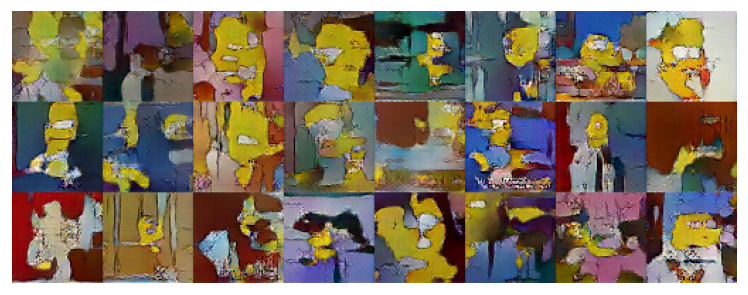

In [16]:
from mindspore import load_checkpoint
#from mindvision import dataset

# 从文件中获取模型参数并加载到网络中
param_dict = load_checkpoint("./Generator300.ckpt", netG)

img64 = netG(fixed_noise).transpose(0, 2, 3, 1).asnumpy()

fig = plt.figure(figsize=(8, 3), dpi=120)
images = []
for i in range(3):
    images.append(np.concatenate((img64[i * 8:(i + 1) * 8]), axis=1))
img = np.clip(np.concatenate((images[:]), axis=0), 0, 1)
plt.axis("off")
plt.imshow(img)
plt.show()

生成的图挺恐怖的，但是大致还能看轮廓，这是调了很久的参数才得到的